# Racial and ethnic disparities in COVID‐19 testing 

#### By: Tony Liang, Jack Fan, Minghao Wang

## 1. Introduction

### 1.1 Background information on the topic

A growing body of research suggests that race and ethnicity may affect the infection rates of Covid-19.
Race and ethnicity can be essential factors affecting novel Coronavirus infection rates, including different socioeconomic status, the different history of degree of coronavirus exposure (Ethnic groups with less coronavirus exposure may be more susceptible to Covid-19), the easiness of access to health care and the probability of exposure to the virus concerning occupations such as hospital personnel or airport staff. Because where people live and work affects their health, over time, these factors contribute to different health risks for different racial and ethnic groups. 

### 1.2 The Question 

Through this group project, we wish to answer the question: 
We want to compare whether there are specific or significant differences in the proportion of tested positive of Covid-19 among Black, White, Latin and Asian people in the State of USA with most cases in 2021(to be determined). In our case, compare proportion of `Cases_White`, `Cases_Black`, `Cases_Asian`, `Cases_latinx` from `Cases_Total` and use `State` as grouping variable.

### 1.3 The Dataset

To answer the question mentioned above, we will use the CRDT Data Set. This dataset is based on the states' race and ethnicity reports on the pandemic across the United States, collected by Boston University Center for Antiracist Research. It is consist of several numerical variables (cases, deaths of different races) and one categorical variable (State). For more information on the data we used, you can find on the [Covid Tracking Project](https://covidtracking.com/race/about#download-the-data).

## 2. Preliminary Results

### 2.0 Libraries and Packages

In [49]:
library(tidyverse)
library(readr)
library(tidyr)
library(dbplyr)
library(lubridate)
library(ggplot2)
library(ggrepel)

### 2.1 Read the data into R

In [3]:
df <- read_csv("../data/crdt-data.csv")
cat("The dimenstion of this dataframe is: ", dim(df)[1], "x", dim(df)[2])
head(df)


Rows: 5320 Columns: 54

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (1): State
dbl (53): Date, Cases_Total, Cases_White, Cases_Black, Cases_Latinx, Cases_A...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



The dimenstion of this dataframe is:  5320 x 54

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,...,Tests_Latinx,Tests_Asian,Tests_AIAN,Tests_NHPI,Tests_Multiracial,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AK,59332,18300,1499,NA,2447,12238,1508,4453,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AL,499819,160347,82790,NA,2273,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AR,324818,207596,50842,NA,2913,1070,3358,1804,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AS,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AZ,826454,308453,25775,244539,11921,40707,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,CA,3501394,546630,111279,1509103,186562,9025,15281,42824,...,9444459,3980518,98894,222513,74171,6354689,18567612,9444459,21633943,18567612


After reading data, we noticed that this raw data consists of 5320 observations (rows) and 54 variables (columns), whereas there exist many NA values. This suggests that we need to clean and wrangle it into a tidier data to work with, plus, selecting our interest variables. We are interested in estimating proportions of tested positive among selected ethnicities, and categorize them by `Date`, `State`. Hence, we will only keep the following variables:

`Cases_Total`, `Cases_White`, `Cases_Black`, `Cases_Latinx`, `Cases_Asian`, `Date`,`State`. 
<br>
</br>
And for the simplicity of this project, we will assume these data were Missing Completely At Random (MCAR), therefore dropping all NA values. 

### 2.2 Clean and wrangle data into a tidy format

In [4]:
cases_piped <- df %>%
    select(Date, State, Cases_Total:Cases_Asian) %>%
    drop_na()
head(cases_piped)
cat("The dimenstion of cases_piped is: ", 
    dim(cases_piped)[1], "x", dim(cases_piped)[2])

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AZ,826454,308453,25775,244539,11921
20210307,CA,3501394,546630,111279,1509103,186562
20210307,CO,435762,181669,12637,119224,6406
20210307,CT,285330,85469,19651,41523,3019
20210307,DE,88354,42730,19768,14532,1842
20210307,GA,1023487,319208,216068,85460,17888


The dimenstion of cases_piped is:  1941 x 7

After selecting only those interested variables (mentioned above) and dropping the NA values, we noticed the data is still a bit large and unorganized, plus, `Date` is shown in YYYYMMDD format, and the total number states is also unknown. Hence, we will separate this `Date` column into `Year`, `Month`, `Day`, then look for time spread, plus, unique values of States in here as data formatted as reports on cases from all states weekly.

In [153]:
cases_tidy <- cases_piped %>%
           mutate(Date = lubridate::ymd(Date),
                  Year = lubridate::year(Date),
                  Month = lubridate::month(Date),
                  Day = lubridate::day(Date)) %>%
           select(-Date)

years <- cases_tidy %>%
         select(Year) %>%
         unique() %>%
         t() 

n_states <- length(unique(cases_tidy$State))

cat("The total number of States in this dataframe is: ", n_states, "\n")
years

The total number of States in this dataframe is:  23 


Year,2021,2020


The tidy data only contains observations of `Year` of 2021 and 2020, and total of 23 states. Then, we will find only in `Year = 2021` , `State` whose occured most cases by adding them all together and assigned it to a dataframe called `max_cases`.

In [154]:
options(repr.plot.width = 10, repr.plot.height = 10)
max_cases <- cases_tidy %>%
           filter(Year == 2021) %>%
           ungroup() %>%
           select(-Year) %>%
           group_by(State) %>%
           summarize(Cases = sum(Cases_Total)) %>% arrange(desc(Cases))
head(max_cases)

State,Cases
<chr>,<dbl>
CA,59965176
TX,44566324
IL,21237113
GA,14980746
AZ,13994015
NJ,13146347


A visualization of total number of positive cases of these 23 states is represented at section 2.3 (See below)

Given the dataframe above, California (CA) has highest number of positive cases of the pandemic in 2021, so we will focus on `State == "CA"` and in `Year == 2021` only

In [147]:
tidy_ca <- cases_tidy %>%
           filter(State == "CA", Year == 2021) %>%
           select(-Year, -Day)
head(tidy_ca)

State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian,Month
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CA,3501394,546630,111279,1509103,186562,3
CA,3484963,541927,110115,1494376,184765,3
CA,3475562,539466,109591,1487225,183711,2
CA,3455361,534330,108479,1472040,181664,2
CA,3441946,530958,107741,1462751,180258,2
CA,3416147,524753,106400,1446427,177919,2


### 2.3 Plot the relevant raw data, tailoring your plot in a way that addresses your question.

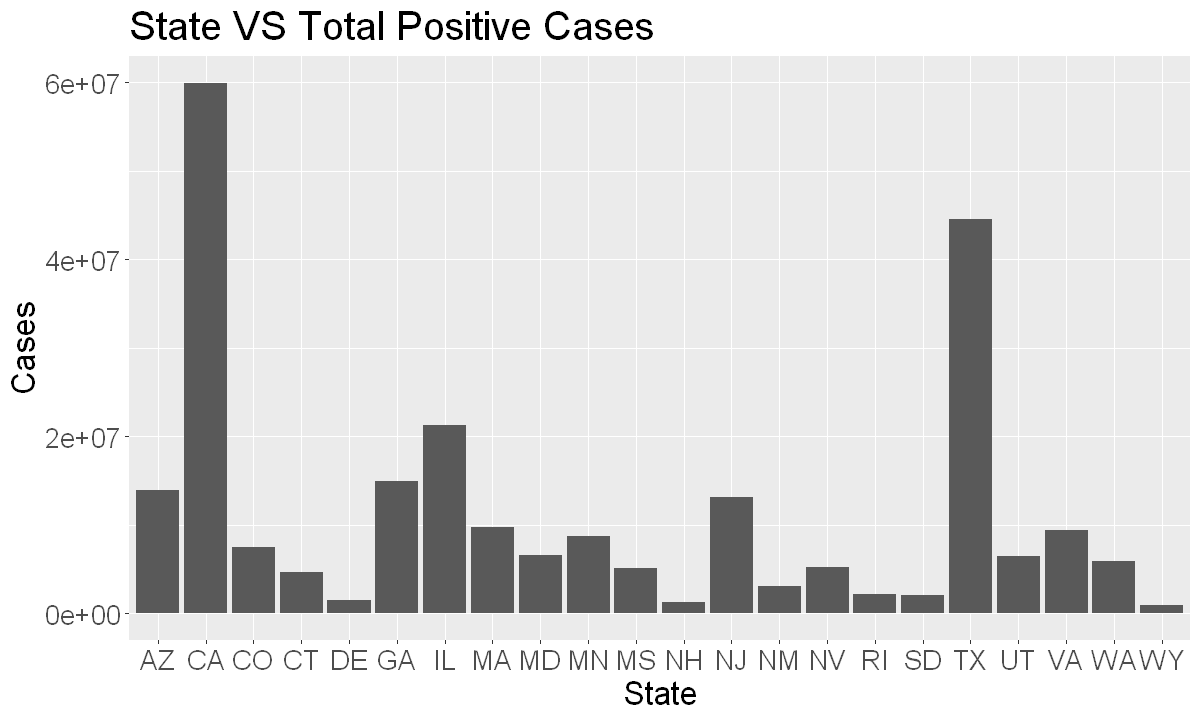

In [146]:
options(repr.plot.width=10, repr.plot.height=6)
cases_plot <- ggplot(max_cases, aes(x = State, y = Cases)) + 
              geom_bar(stat = "identity") + 
              labs(title = "State VS Total Positive Cases") +
              theme(text = element_text(size = 20))
cases_plot


By the plot above, total positive cases of California is significantly higher than other states, therefore, we would focus on California's data only , and calculate the proportion of different ethinicities getting tested positive for COVID-19 eg. for white, black, asian and latin people during the year of 2021.

### 2.4 Compute estimates 

*Compute estimates of the parameter you identified across your groups. Present this in a table. If relevant, include these estimates in your plot.*

In [144]:
cali_prop <- cases_tidy %>%
              filter(State == "CA", Year == 2021) %>%
              summarize(total_pos = sum(Cases_Total),
                        Asian = sum(Cases_Asian) / sum(total_pos),
                        Black = sum(Cases_Black) / sum(total_pos),
                        Latinx = sum(Cases_Latinx) / sum(total_pos),
                       White = sum(Cases_White) / sum(total_pos)) %>%
               select(-total_pos) %>%
              pivot_longer(cols = 1:4,
                          names_to = "ethnicity") %>%
              rename(proportion = value) %>%
              arrange(desc(proportion))

cali_prop

ethnicity,proportion
<chr>,<dbl>
Latinx,0.41705729
White,0.15091456
Asian,0.05050680
Black,0.03264898


Although, these statistics are of special case, as mentioned before, attention is only given on these four races: `White`, `Black`, `Asian`, and `Latinx`, hence, these proportions will not add up to 1, but when visualizing it, R have automatically tune it to sum to 1 ratio. Below is the visualization of these summary statistics(estimates):

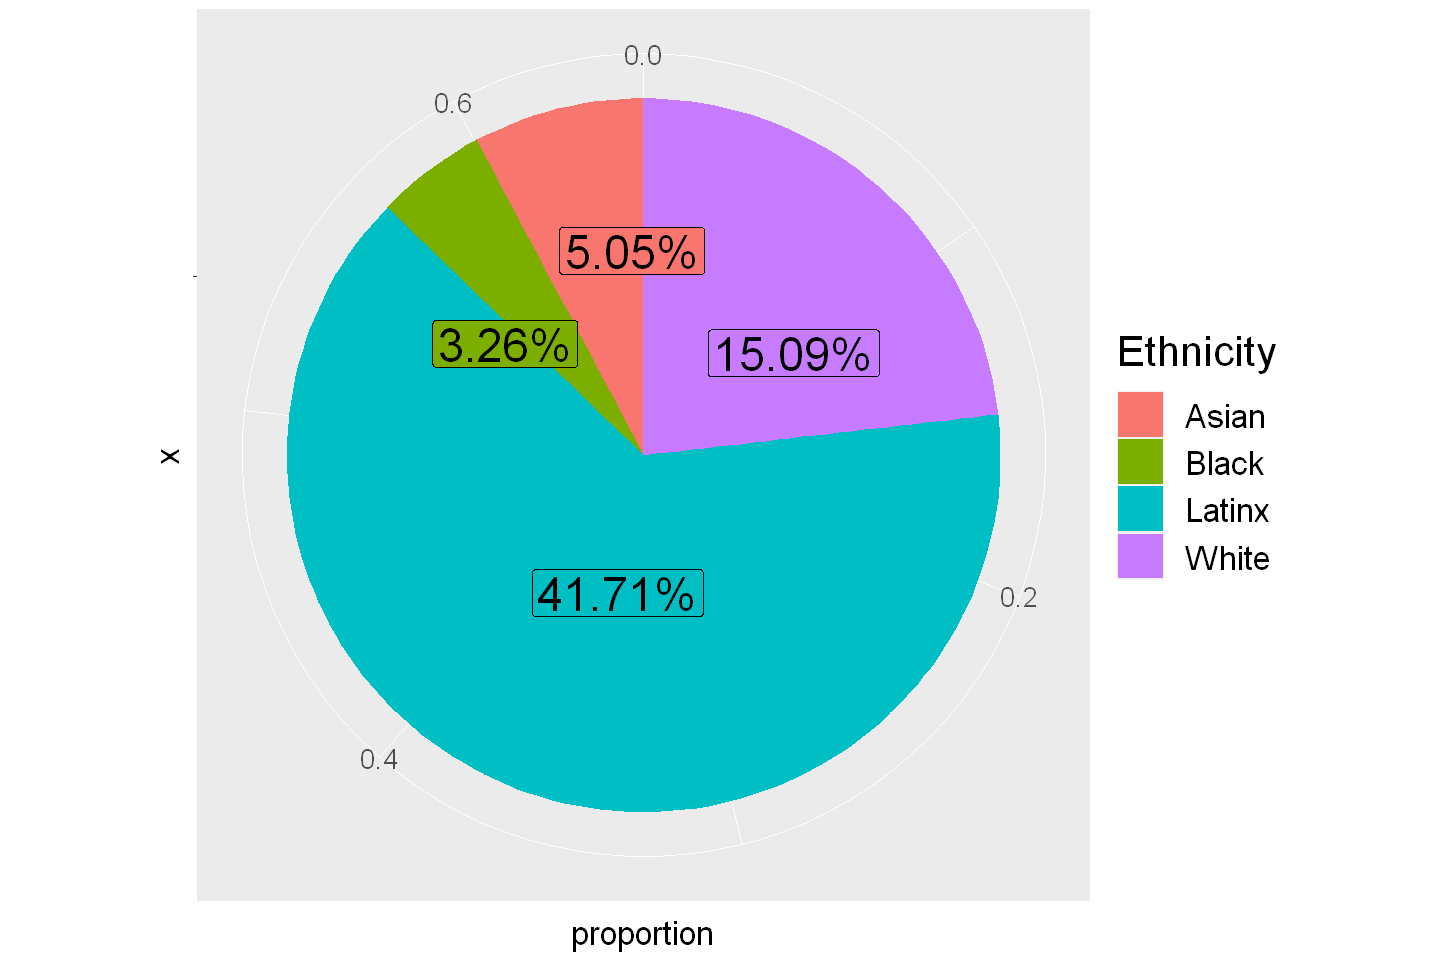

In [145]:
options(repr.plot.width = 12, repr.plot.height = 8)
pie <- ggplot(cali_prop, aes(x = "", y = proportion, fill = ethnicity)) +
     geom_bar(width = 1, stat = "identity") +
     coord_polar(theta = "y") +
     theme(text = element_text(size = 20),
         legend.key.size = unit(1, "cm"),
           legend.key.height = unit(1, "cm"),
            legend.key.width = unit(1, "cm"),
            legend.title = element_text(size = 25),
            legend.text = element_text(size = 20)) +
          geom_label_repel(aes(label = paste0(round(proportion * 100, 2), "%")),
                               size = 10,
                           show.legend = F, position = position_stack(vjust = 0.5)) + 
       guides(fill = guide_legend(title = "Ethnicity")) 
pie

# 3. Methods: Plan

### 3.1 What do you expect to find?

By doing this project, we want to explore and find out if distinct races have different chances of catching COVID-19, or they all races have the same chance. We are expecting to use hypothesis tests to determine if proportions of positive cases are same in our 4 chosen ethnicities and test it at a significance level of $\alpha = 0.05$:

Let the following be our hypotheses:

$H_o:$ The proportion of tested positive is same in each ethnicity$: p_a = p_b = p_l = p_w$

$H_a:$ The proportion of tested positive is not the same in each ethnicity$:$
at least one $p_i, i \in \{a,b,l,w\}$ is different from the others.

At $\alpha = 0.05$

Moreover, to further test it, we might apply ANOVA testing or other alternative lie Fisher's exact test, considering the relative small sample size of our tidy data. Note, In our data analysis conducting bootstrapping would not be feasible and irrevelant due to variable and data format restriction.


### 3.2 What impact could such findings have?

The impact of our findings could help raise the awareness of COVID-19 and other diseases, and not just for a specific race but for all. It could also help explain why different regions or countries have specific measurements of cases of COVID-19 as compared to others. On top of that, the governments around the world could implement different regulations and medical procedures for its citizens to help control different diseases.

### 3.3 What future questions could this lead to?

As mentioned above, the result of this project could lead to various questions. These include why is this the case, what can a specific race do to lower the chance of getting infected from different diseases, what can they do to improve their health status and their immune system, what should they be aware of, what are the effects and so on. The importance of this project is unquestionable, and the result of this project can lead to evolutionary questions to modern health questions.

## 4. Reference


Mankowski, N., Al-Qurayshi, Z., Souza, S., Campbell, B., Beighley, A., Denson, J., Mauldin, B., Bojanowski, C., Friedlander, P., & Zifodya, J. (2021). The Effect of Race, Socioeconomic Status, and Comorbidity on Patients Afflicted with COVID 19: A Local Perspective. Annals of Epidemiology. https://doi.org/10.1016/j.annepidem.2021.09.013
<br>

Credit, K. (2020). Neighbourhood inequity: Exploring the factors underlying racial and ethnic disparities in COVID‐19 testing and infection rates using ZIP code data in Chicago and New York. Regional Science Policy & Practice, 12(6), 1249–1271. https://doi.org/10.1111/rsp3.12321

About the Racial Data Tracker. (n.d.). The COVID Tracking Project. Retrieved March 6, 2022, from https://covidtracking.com/race/about#download-the-data
‌